# Event-based Constellation Example

This notebook illustrates how to run many PASEOS instances in parellel to model a constellation in low-Earth orbit (LEO). 

First, let's import all necessary modules

In addition to PASEOS's requirements this notebook uses seaborn and pandas. `conda install seaborn` or `pip install seaborn` will get it. (analogously for pandas)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys 
sys.path.append("../..")

import warnings
warnings.filterwarnings("ignore")

import pykep as pk
import numpy as np
import paseos
from paseos import ActorBuilder, SpacecraftActor, GroundstationActor
paseos.set_log_level("WARNING") # use info / debug if you want more insight

10:53:38|PASEOS-DEBUG| Setting LogLevel to DEBUG
10:53:38|PASEOS-DEBUG| Loaded module.


### Constellation setup

In addition to the code in this notebook, we use a simple function that automatically computes the orbits of a [Walker Constellation](https://en.wikipedia.org/wiki/Satellite_constellation#Walker_Constellation) for us. It allows us to only specify a few parameters to get started.

For illustrative purposes our constellation will consist of 16 satellites in LEO and one communication satellite in GEO. Feel free to change the numbers to try out different setups.

In [2]:
from get_constellation import get_constellation
altitude = 550 * 1000 # Constellation attitude above the Earth's ground
inclination = 10.0 # inclination of each orbital plane
nPlanes = 4 # the number of orbital planes (see linked wiki article)
nSats = 4 # the number of satellites per orbital plane
t0 = pk.epoch_from_string("2023-Jan-04 20:00:00") # the starting date of our simulation

# Compute orbits of LEO satellites
planet_list,sats_pos_and_v,orbital_period = get_constellation(altitude,inclination,nSats,nPlanes,t0)

# Compute orbit of GEO communications satellite
comms_sat,comm_sat_pos_and_v,_ = get_constellation(35786*1000,0,1,1,t0)

Created 16 satellites...
Computing constellation's positions and velocities...
Done!
Created 1 satellites...
Computing constellation's positions and velocities...
Done!


Let's briefly plot our satellite orbits for illustrative purposes. We use [pykep's plotting features](https://esa.github.io/pykep/documentation/orbitplots.html) for that.

Note that angles aren't to scale in pykep plots.

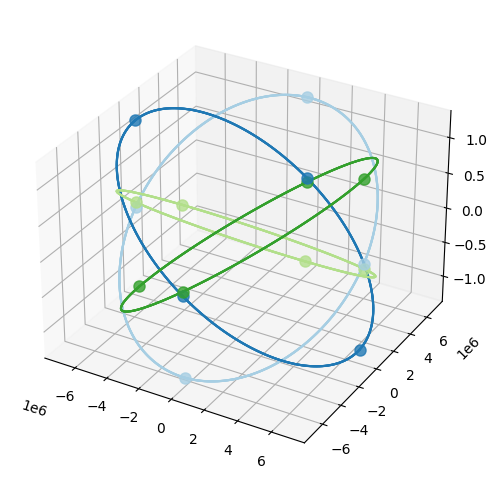

In [3]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d')
colors = sns.color_palette("Paired")
for i in range (nPlanes*nSats):
    color_idx = i // nPlanes
    pk.orbit_plots.plot_planet(planet_list[i],axes=ax,s=64,color=colors[color_idx])
# pk.orbit_plots.plot_planet(comms_sat[0],axes=ax,s=64)

### PASEOS Setup

Now we will create a PASEOS instance for each LEO satellite. Further, we add a communication device, power device and a thermal model.

Pleae have a look at the [readme sections on physical models](https://github.com/aidotse/PASEOS#physical-models) for additional details.

In [4]:
paseos_instances = [] # this will store paseos instances
earth = pk.planet.jpl_lp("earth") # define our central body

for idx,sat_pos_v in enumerate(sats_pos_and_v):
    pos,v = sat_pos_v
    sat_actor = ActorBuilder.get_actor_scaffold(name="Sat_"+str(idx),
                                                actor_type=SpacecraftActor,
                                                epoch=t0)
    ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
    ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)
    ActorBuilder.set_power_devices(actor=sat_actor,battery_level_in_Ws=10000+np.random.rand()*90000,
                                   max_battery_level_in_Ws=100000,charging_rate_in_W=50)
    ActorBuilder.set_thermal_model(
            actor=sat_actor,
            actor_mass=50.0,
            actor_initial_temperature_in_K=273.15,
            actor_sun_absorptance=1.0,
            actor_infrared_absorptance=1.0,
            actor_sun_facing_area=2.0,
            actor_central_body_facing_area=2.0,
            actor_emissive_area=4.0,
            actor_thermal_capacity=1000
    )
    
    instance = paseos.init_sim(local_actor=sat_actor)
    paseos_instances.append(instance)

For our comms satellite, we skip modelling the thermal and power concerns for simplicity. Further, we add a groundstation on Gran Canaria.

In [5]:
comms_instances = []

gs_actor = ActorBuilder.get_actor_scaffold(name="gs_1",actor_type=GroundstationActor, epoch=t0)
ActorBuilder.set_ground_station_location(gs_actor,latitude=27.7629, longitude=-15.6338, elevation=205.1, minimum_altitude_angle=5)
instance = paseos.init_sim(local_actor=gs_actor)
comms_instances.append(instance)

pos,v = comm_sat_pos_and_v[0]
sat_actor = ActorBuilder.get_actor_scaffold(name="comms_1",actor_type=SpacecraftActor, epoch=t0)
ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)    
instance = paseos.init_sim(local_actor=sat_actor)
comms_instances.append(instance)

We can use PASEOS internal plotting to have a look at our setup now. As of writing the plotting isn't ideal for larger constellations ¯\_(ツ)_/¯

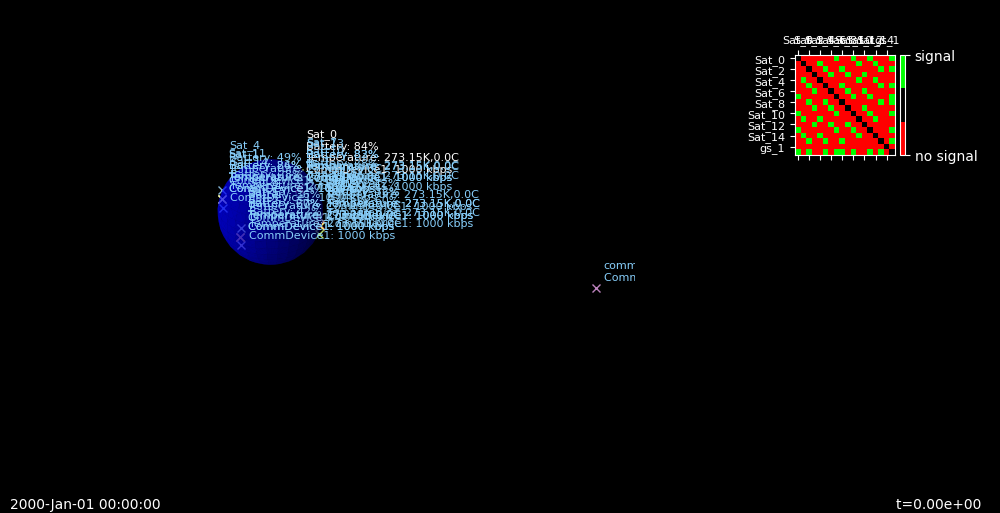

In [6]:
paseos_instances[0].emtpy_known_actors()
for instance in paseos_instances[1:]:
    paseos_instances[0].add_known_actor(instance.local_actor)
for instance in comms_instances:
    paseos_instances[0].add_known_actor(instance.local_actor)
plotter = paseos.plot(paseos_instances[0], paseos.PlotType.SpacePlot)

Now, we define some operational constraints for our constellation. Let's say, our LEO satellites have two tasks:

* Processing - Consumes 100W and can only be performed at < 56.85° C and if our battery is at least 20% charged.
* Charging - What we do if the above constraint is violated

To this end, we define a function hat returns `True` if the constraint is met.

In [7]:
def get_consumption_and_activity(actor):
    """Determine power consumption and activity for an actor."""
    if operational_constraint(actor):
        return 100.0,"Processing"
    else: 
        return 2.0, "Charging"

def operational_constraint(actor):
    """Determine if constraint is met for an actor"""
    if (actor.state_of_charge > 0.2 
        and actor.temperature_in_K < 330):
        return True
    else:
        return False

### Running the simulation

Now, we are ready to run the main simulation. We will simulate the operations of this constellation for 8 hours. Every 600 seconds (or once the constraint is no longer valid) we will redecide whether a satellite is going to "charge" or "process".

Whenever a satellite starts violating the operational constraint, it will stop the activity and continue which charging. This is marked by an `INFO` output from PASEOS.

If the activity is interrupted due to overheating or lack of battery charge, we continue charging for the remaining time of the 600 second window.

In [8]:
simulation_time = 8.0 * 3600 # one day in seconds
t = 0 # starting time in seconds
timestep = 600 # how often we decide what each sat should do [s]

# Run until end of simulation
while t <= simulation_time: 
    N_charging = 0 # track chargers
    N_processing = 0 # track processors
    N_interruped = 0 # track which switched due to constraint
    # For each satellite, we perform the following steps
    for instance in paseos_instances:
        local_t = instance.local_actor.local_time
        # Update known actors, i.e. for each sat if they can
        # see the ground station and the comms satellite
        instance.emtpy_known_actors()
        for comm_instance in comms_instances:
            if instance.local_actor.is_in_line_of_sight(comm_instance.local_actor,epoch=local_t):
                instance.add_known_actor(comm_instance.local_actor)
        
        # Determine whether satellite is processing or charging
        power_consumption, activity = get_consumption_and_activity(instance.local_actor)
        if activity == "Processing":
            N_processing += 1
            eval_constraint = lambda: operational_constraint(instance.local_actor)
        else:
            N_charging += 1
            eval_constraint = None
        
        # This call is only necessary to display running activity 
        # in PASEOS internal monitoring (which we use below)
        instance.local_actor._current_activity = activity

        # Advance the simulation state of this satellite
        # Note how we pass the "eval_constraint" to tell paseos to evaluate if the constraint
        # for running the "Processing" is still satisfied
        time_remaining_to_advance = instance.advance_time(
            time_to_advance=timestep,
            current_power_consumption_in_W=power_consumption,
            constraint_function=eval_constraint
        )

        # If activity was interrupted by constraint violation, proceed charging for remainder
        if time_remaining_to_advance > 0:
            N_interruped += 1
            instance.advance_time(
            time_to_advance=time_remaining_to_advance,
            current_power_consumption_in_W=2.0,
            constraint_function=None
        )

    # Advance the comm satellite and ground station
    for instance in comms_instances:
        instance.advance_time(time_to_advance=timestep,current_power_consumption_in_W=0.0)

    print(f"Time: {t}s - # of Processing = {N_processing} ({N_interruped} interrupted), # of Charging = {N_charging}")
    t += timestep

Time: 0s - # of Processing = 16 (9 interrupted), # of Charging = 0
Time: 600s - # of Processing = 15 (14 interrupted), # of Charging = 1
Time: 1200s - # of Processing = 8 (8 interrupted), # of Charging = 8
Time: 1800s - # of Processing = 12 (12 interrupted), # of Charging = 4
Time: 2400s - # of Processing = 8 (8 interrupted), # of Charging = 8
Time: 3000s - # of Processing = 8 (8 interrupted), # of Charging = 8
Time: 3600s - # of Processing = 4 (4 interrupted), # of Charging = 12
Time: 4200s - # of Processing = 12 (8 interrupted), # of Charging = 4
Time: 4800s - # of Processing = 12 (12 interrupted), # of Charging = 4
Time: 5400s - # of Processing = 8 (4 interrupted), # of Charging = 8
Time: 6000s - # of Processing = 8 (8 interrupted), # of Charging = 8
Time: 6600s - # of Processing = 8 (4 interrupted), # of Charging = 8
Time: 7200s - # of Processing = 12 (12 interrupted), # of Charging = 4
Time: 7800s - # of Processing = 4 (4 interrupted), # of Charging = 12
Time: 8400s - # of Process

### Plotting and Analysis

Alright! Now, let's have a look at what actually happened during our simulation.

For this, we will make use of [PASEOS' monitor](https://github.com/aidotse/PASEOS#monitor).

The below code uses it to extract a few quantities for all our sats and plots them over the course of the simulation for each satellite (each color is one).

This will give us a good impression of whether each satellite's operations are sensible.

We will also accumulate all the data into a [pandas dataframe](https://pandas.pydata.org/docs/user_guide/10min.html) for convenience.

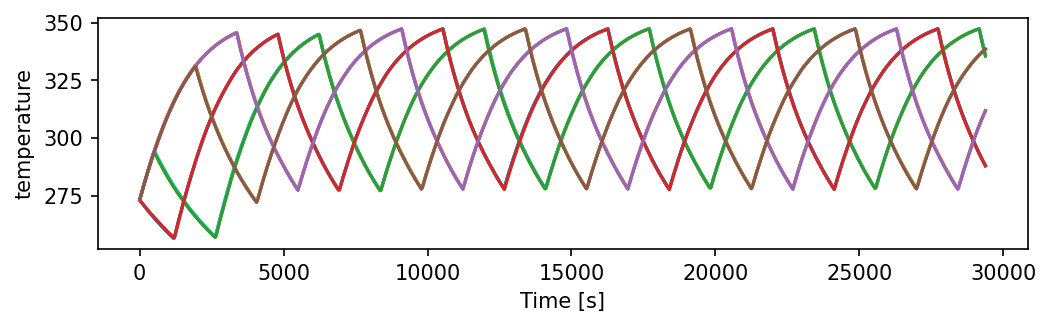

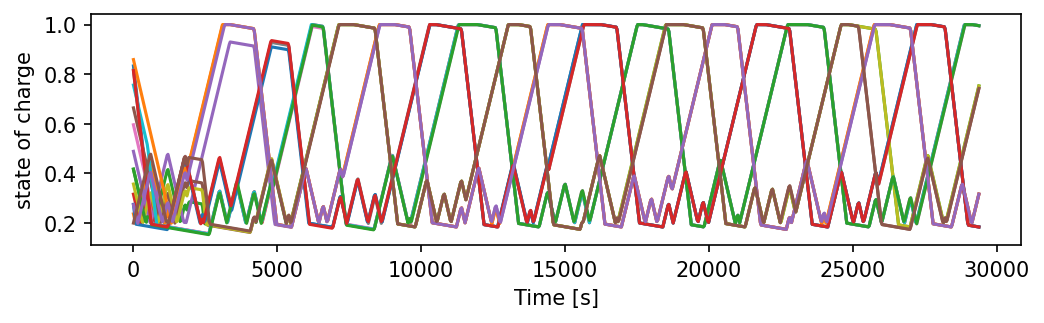

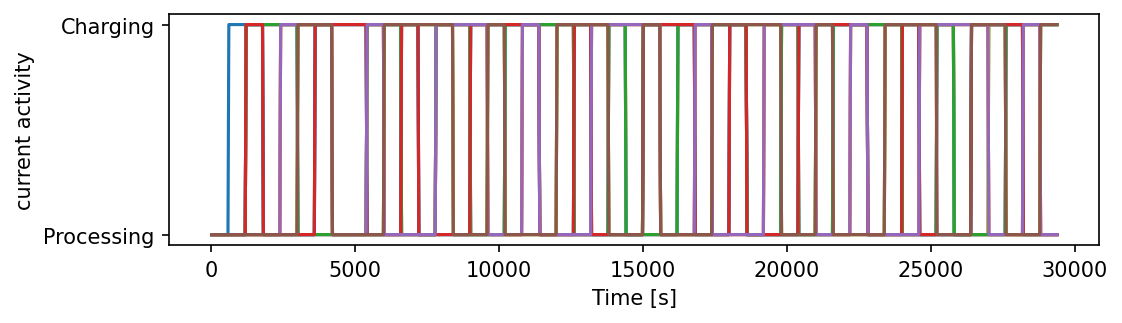

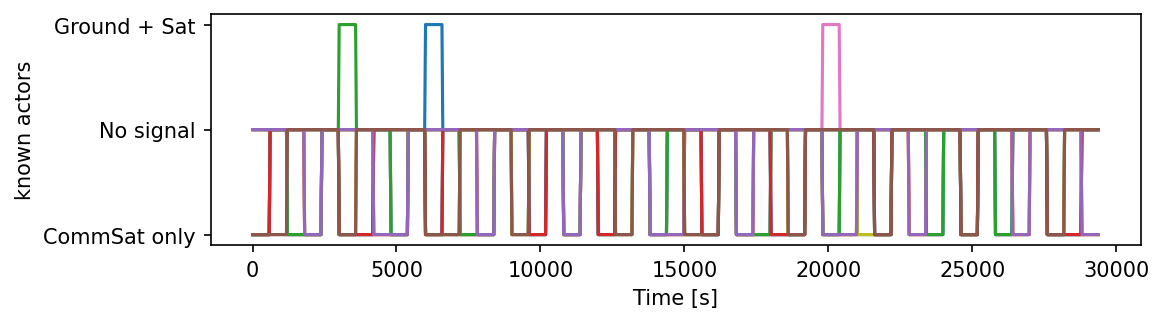

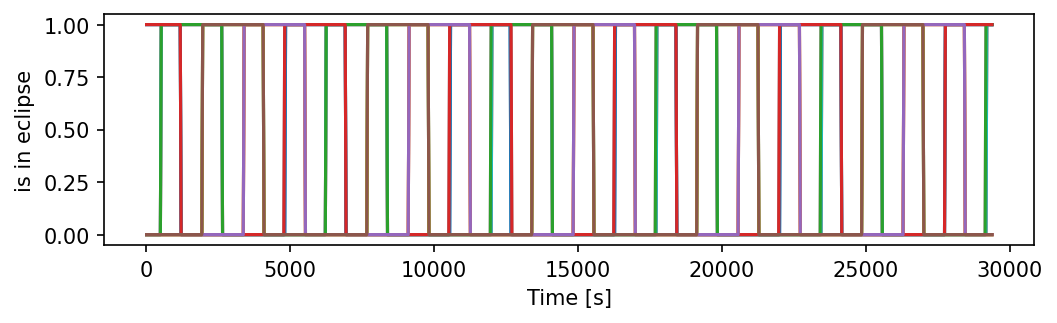

In [9]:
from constellation_example_utils import get_known_actor_comms_status

# Quantities we wanna track
quantities = ["temperature","state_of_charge","current_activity","known_actors","is_in_eclipse"]

# Setup data frame to collect all data
df = pd.DataFrame(columns=("Time","ID"))
for idx,item in enumerate(quantities):
    names = []

    # Dataframe for this quantity
    small_df = pd.DataFrame(columns=("Time","ID"))
    
    plt.figure(figsize=(8, 2),dpi=150)

    # Get dat afrom all satellites and plot it
    for instance in paseos_instances:

        # Get time of each data point
        timesteps = instance.monitor["timesteps"]

        # Get data
        if item == "known_actors":
            values = get_known_actor_comms_status(instance.monitor[item])
        else:
            values = instance.monitor[item]
        names.append(instance.local_actor.name)

        # Collect data from this sat into big dataframe
        smaller_df = pd.DataFrame({"Time": timesteps,"ID": len(timesteps)*[instance.local_actor.name],item: values})
        if item == "is_in_eclipse": #pandas things...
            smaller_df["is_in_eclipse"] = smaller_df["is_in_eclipse"].astype("boolean")
        small_df = pd.concat([small_df,smaller_df])
        
        # Plot it :)
        plt.plot(timesteps,values)
        plt.xlabel("Time [s]")
        plt.ylabel(item.replace("_", " "))

    # Add a legend showing which satellite is which
    # plt.legend(
    #         names,
    #         fontsize = 8,
    #         bbox_to_anchor=(0.5, 1.4),
    #         ncol=10,
    #         loc="upper center",
    # )
    
    df = df.merge(small_df,how="right")

### Constellation Analysis

Now let's focus on analysing the whole constellation.

Let's begin by tracking the total number of satellites that are processing and charging, respectively. Then we will also plot their communication status.

We will do some pandas magic in the background to make this easy. The below cell may take a few seconds.

In [10]:
from constellation_example_utils import get_analysis_df
N_timesteps = 20
df["Completed orbits"] = df.Time / orbital_period
analysis_df = get_analysis_df(df,df.Time.max() // N_timesteps,orbital_period)
analysis_df.head()

,Time[s],# of Charging,# of Processing,# in Eclipse,# of CommSat only,# of Ground + Sat,# of No signal,Completed orbits,Share Processing,Share in Eclipse
0,0.0,0,16,4,8,0,8,0.00,1.00,0.25
1,1546.0,8,8,4,4,0,12,0.27,0.50,0.25
2,3093.0,8,8,4,7,1,8,0.54,0.50,0.25
3,4639.0,4,12,4,4,0,12,0.81,0.75,0.25
4,6185.0,8,8,4,7,1,8,1.08,0.50,0.25


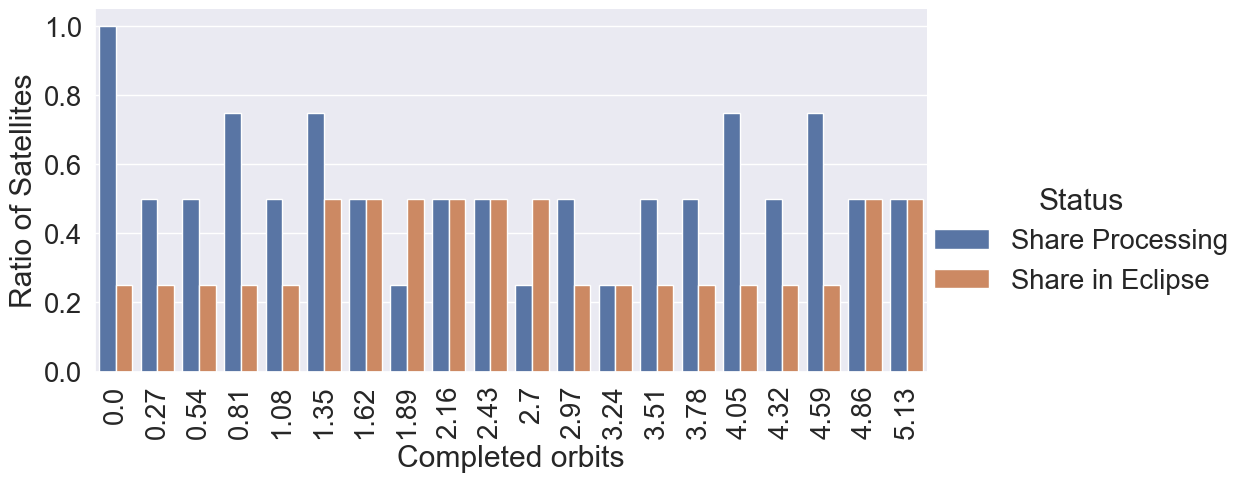

In [11]:
sns.set(font_scale=1.8)
melt_df = analysis_df[["Completed orbits",'Share Processing', 'Share in Eclipse']].melt('Completed orbits', var_name='Status', value_name='Ratio of Satellites')
g = sns.catplot(x="Completed orbits", y="Ratio of Satellites", hue='Status', data=melt_df, kind='bar',aspect=2)
g.set_xticklabels(rotation=90)

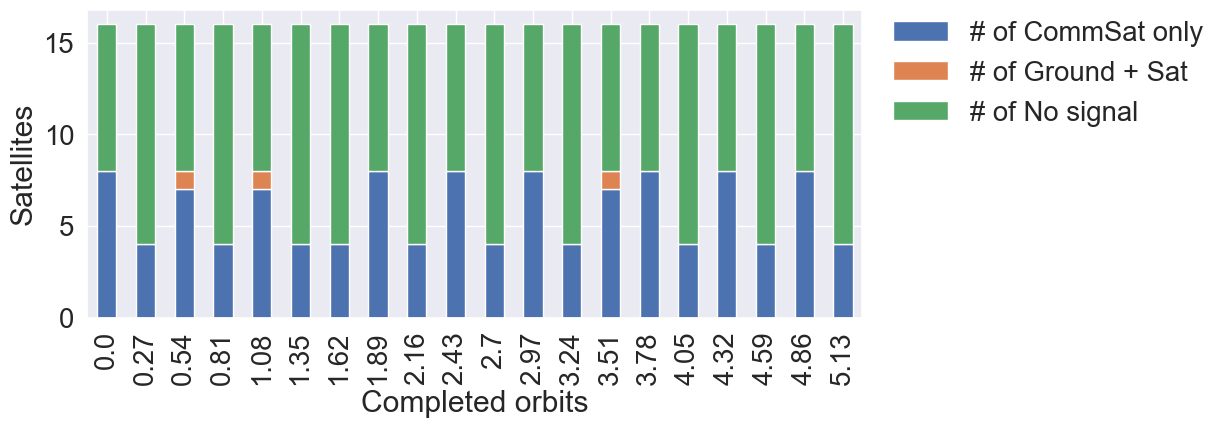

In [12]:
fig,ax = plt.subplots(figsize=(10,4),dpi=100)
subset = ["Completed orbits",'# of CommSat only', '# of Ground + Sat','# of No signal']
analysis_df[subset].plot(x="Completed orbits",kind='bar', stacked=True,ax=ax,color=sns.color_palette()[0:4])
plt.xlabel('Completed orbits')
plt.ylabel('Satellites')
plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0,frameon=False)

Now, let's have a look at operational temperatures and state of charge. We plot the mean and 25%, 50%, 100% percentile intervals (PI) in different colors respectively.

Text(0, 0.5, 'Temperature [K]')

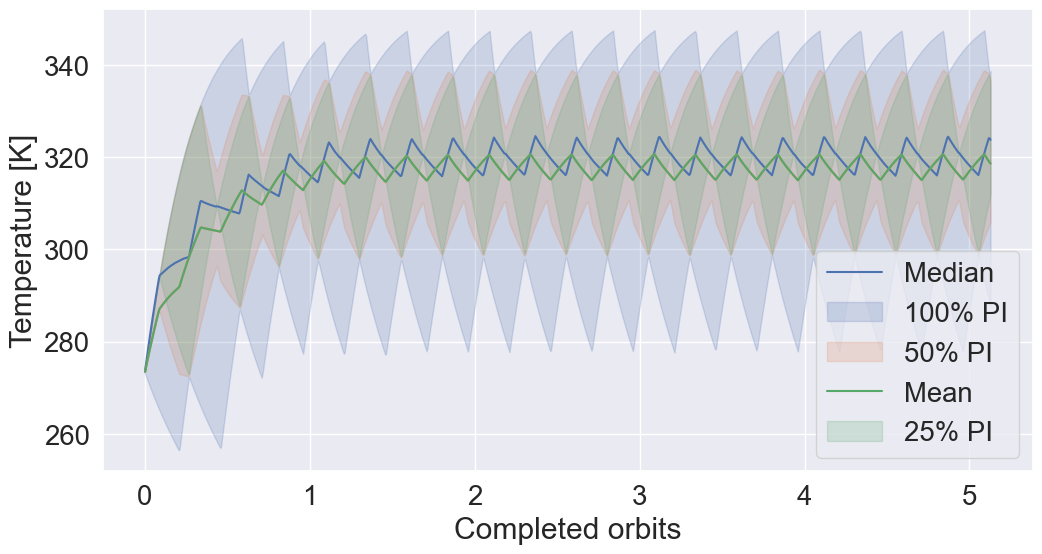

In [13]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale=1.8)
sns.lineplot(data=df,x="Completed orbits",y="temperature",errorbar=("pi",100),estimator="median")
sns.lineplot(data=df,x="Completed orbits",y="temperature",errorbar=("pi",50))
sns.lineplot(data=df,x="Completed orbits",y="temperature",errorbar=("pi",25))
plt.legend(["Median","100% PI","_","50% PI","Mean","25% PI",]);
plt.ylabel("Temperature [K]")

Text(0, 0.5, 'State of Charge')

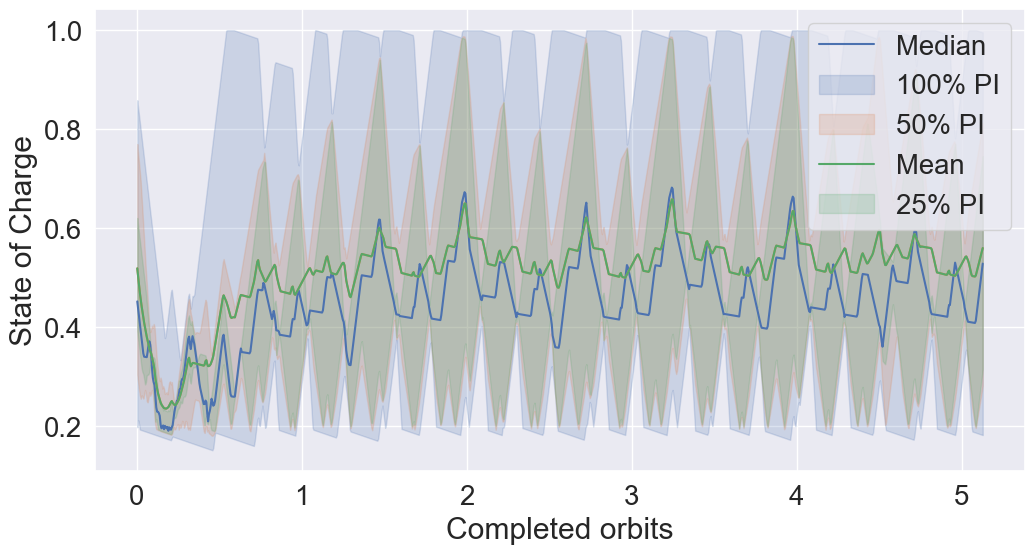

In [14]:
sns.lineplot(data=df,x="Completed orbits",y="state_of_charge",errorbar=("pi",100),estimator="median")
sns.lineplot(data=df,x="Completed orbits",y="state_of_charge",errorbar=("pi",50))
sns.lineplot(data=df,x="Completed orbits",y="state_of_charge",errorbar=("pi",25))
plt.legend(["Median","100% PI","_","50% PI","Mean","25% PI",]);
plt.ylabel("State of Charge")